In [1]:
from tensoraerospace.agent.pid import PIDController
import numpy as np
from ray import train, tune

from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step

import gymnasium as gym 
from tensoraerospace.benchmark.function import overshoot, settling_time, static_error
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


In [85]:
import numpy as np



class PIDController:
    def __init__(self, kp, ki, kd, dt):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integral = 0
        self.prev_error = 0
        self.writer = SummaryWriter()

    def update(self, setpoint, measurement):
        error = setpoint - measurement
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        output = (self.kp * error) + (self.ki * self.integral) + (self.kd * derivative)
        self.prev_error = error
        return output

    def twiddle(self, tol=0.2, iters=100):
        p = [self.kp, self.ki, self.kd]
        dp = [0.1 * pk for pk in p]  # Start with 10% of each coefficient
        best_err = float('inf')

        for _ in tqdm(range(iters)):
            for i in range(len(p)):
                p[i] += dp[i]
                self.set_pid(p[0], p[1], p[2])
                err = self.run_simulation()

                if err < best_err:  # There was improvement
                    best_err = err
                    dp[i] *= 1.1
                else:  # No improvement
                    p[i] -= 2 * dp[i]  # Try going in the opposite direction
                    self.set_pid(p[0], p[1], p[2])
                    err = self.run_simulation()
                    self.writer.add_scalar("Error", err, _)
                    if err < best_err:
                        best_err = err
                        dp[i] *= 1.1
                    else:
                        p[i] += dp[i]
                        dp[i] *= 0.9

                if abs(sum(dp)) < tol:  # Stop if changes are too small
                    # print("sum(dp)", sum(dp))
                    break

        self.kp, self.ki, self.kd = p  # Update the coefficients permanently

    def set_pid(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd

    def run_simulation(self):
        # Placeholder for the simulation method
        # Получение исходных сигналов для анализа
        hist = []
        dt = 0.01
        tp = generate_time_period(tn=25, dt=dt)
        tps = convert_tp_to_sec_tp(tp, dt=dt)
        number_time_steps = len(tp)

        # Создание заданного сигнала
        reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=1, output_rad=True), [1, -1])

        # Настройка модельной среды
        env = gym.make('LinearLongitudinalF16-v0',
                    state_space = ["theta", "q"],
                    control_space =['stab'],
                    output_space = ['theta', 'q'],
                    number_time_steps=number_time_steps, 
                    initial_state=[[0],[0],[0],[0]],
                    reference_signal=reference_signals,
                    tracking_states=["theta"])
        state, info = env.reset()
        # Инициализация ПИД-регулятора
        xt = [0,0]
        # Цикл моделирования среды
        for step in range(number_time_steps - 2):
            setpoint = reference_signals[0, step]
            hist.append(xt[0])
            ut = self.update(setpoint, xt[0])
            xt, reward, terminated, truncated, info = env.step([ut])

        # Условие для досрочного прекращения оптимизации
        if 6 < max(hist):
            return 10000

        # Получение исходных сигналов для анализа
        system_signal_orig = env.unwrapped.model.get_state('theta', to_deg=True)[:2500]
        control_signal_orig = np.rad2deg(reference_signals[0])[:2500]

        return np.sqrt(np.mean((np.abs(static_error(control_signal_orig, system_signal_orig)))**2))



In [93]:
pid = PIDController(ki=1,kp =1, kd=1, dt=0.01)

In [94]:
pid.run_simulation()

171.92132427290153

In [95]:
for _ in range(5):
    pid.twiddle(iters=300)

100%|██████████| 300/300 [00:42<00:00,  6.98it/s]


In [96]:
pid.ki, pid.kd, pid.kp

(1.0000000000000002, 1.0000000000000004, 1.6105100000000099)

In [100]:
hist = []
dt = 0.01
tp = generate_time_period(tn=25, dt=dt)
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp)

# Создание заданного сигнала
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=1, output_rad=True), [1, -1])

# Настройка модельной среды
env = gym.make('LinearLongitudinalF16-v0',
                    state_space = ["theta", "q"],
                    control_space =['stab'],
                    output_space = ['theta', 'q'],
                    number_time_steps=number_time_steps, 
                    initial_state=[[0],[0],[0],[0]],
                    reference_signal=reference_signals,
                    tracking_states=["theta"])

state, info = env.reset()
# Инициализация ПИД-регулятора
new_pid = PIDController(kp=pid.kp, ki=pid.ki, kd=pid.kd, dt=dt)

xt = [0,0]
# Цикл моделирования среды
for step in range(number_time_steps - 2):
    setpoint = reference_signals[0, step]
    hist.append(xt[0])
    ut = new_pid.update(setpoint, xt[0])
    xt, reward, terminated, trunkated, info = env.step([ut])

AttributeError: 'PIDController' object has no attribute 'optimize_coefficients'

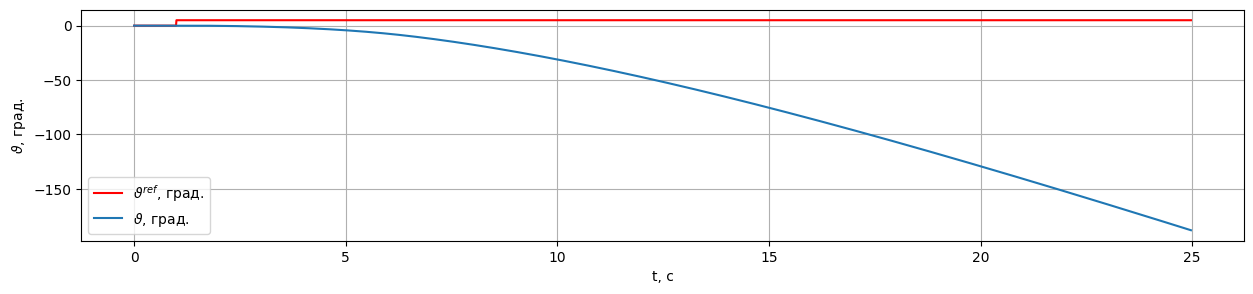

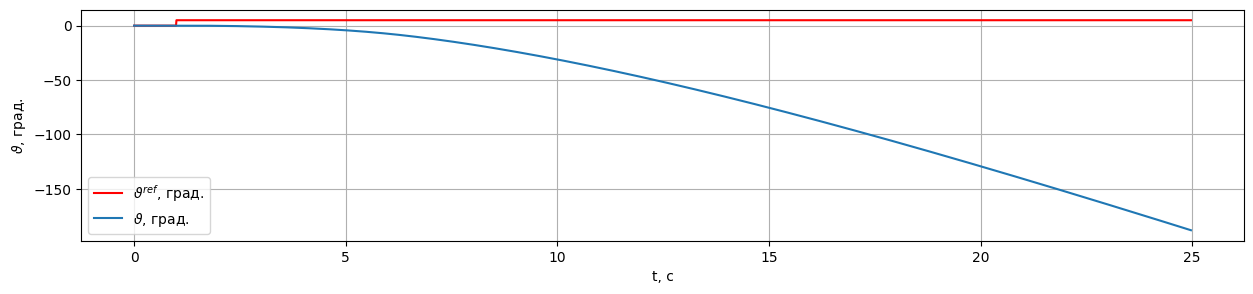

In [98]:
env.unwrapped.model.plot_transient_process(state_name="theta", time=tps, figsize=(15, 3), to_deg=True, ref_signal=reference_signals[0][:2498])

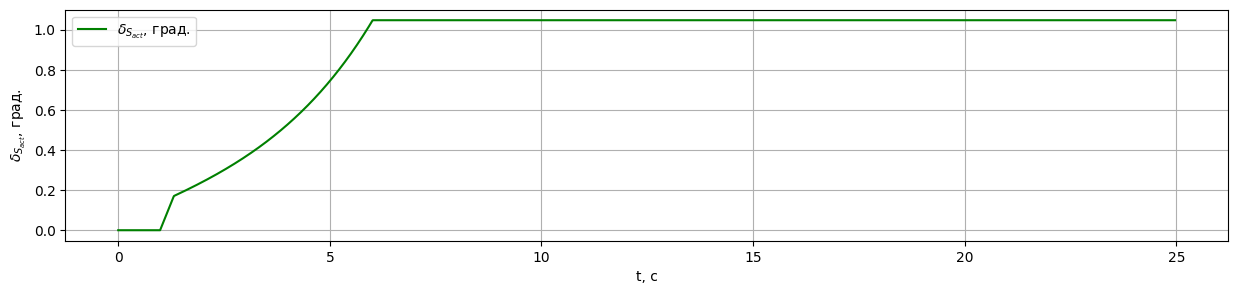

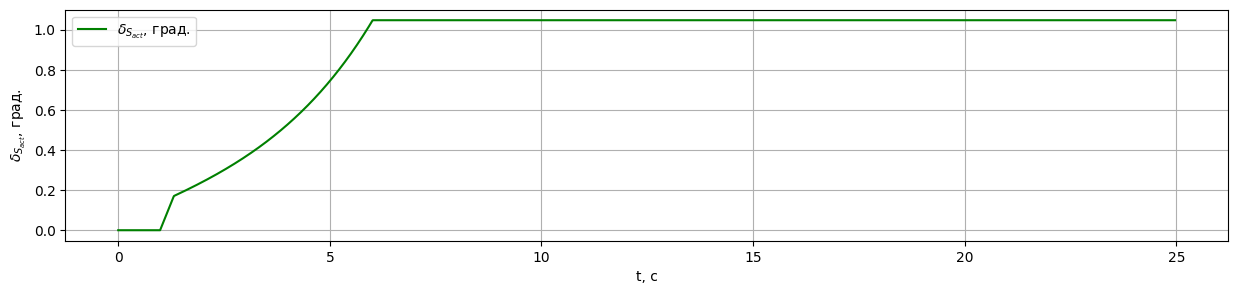

In [99]:
env.unwrapped.model.plot_control(control_name="ele", time=tps, figsize=(15, 3))